# Mask R-CNN Instance Segmentation

In the previous notebooks, we performed object detection, where bounding boxes were used to indicate the objects contained in an image.  In this notebook, we will introduce [Mask R-CNN](https://arxiv.org/abs/1703.06870) for instance segmentation.  In other words, we will get the contours or masks of objects in an image besides bounding boxes.

## Image Segmentation

Image segmentation categorises pixels in an image into different groups in terms of some criteria, such as semantic segmentation and instance segmentation.  In this notebook, we are interested in instance segmentation which will not only detect the known objects in an image with bounding boxes, but also find which pixels belong to the objects using masks.

<img src="./media/segmentaion_comparison.png" width="1000"/>

## Mask R-CNN

[Mask R-CNN](https://arxiv.org/abs/1703.06870) is an instance segmentation algorithm based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497) and adds an extra branch for predicting segmentation masks for object instances.  That is, the same feature map for training the RPN (Region Proposal Network) and classifier in Faster R-CNN is also used in Mask R-CNN by a FCN (Fully Convolutional Network) to predict a binary mask for the object inside a bounding box.

<img src="./media/mask-r-cnn-framework.png" width="600"/>

## Initialization

In [1]:
import sys

sys.path.append("../../")

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import scrapbook as sb
import torch
import torchvision

from utils_cv.common.data import unzip_url, get_files_in_directory
from utils_cv.common.gpu import is_windows, which_processor
from utils_cv.common.plot import show_ims
from utils_cv.detection.data import Urls, coco_labels
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.model import DetectionLearner, get_pretrained_maskrcnn
from utils_cv.detection.plot import plot_detections, plot_pr_curves

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
Torch is using GPU: Tesla V100-PCIE-16GB


In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Next, set some model runtime parameters. We use the unzip_url helper function to download and unzip the data used in this example notebook.

In [3]:
DATA_PATH = unzip_url(Urls.fridge_objects_mask_path, exist_ok=True)
EPOCHS = 10
THRESHOLD = 0.5
IM_SIZE = 500

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## Browse the Dataset

We are going to use the [odFridgeObjectsMask dataset](https://cvbp.blob.core.windows.net/public/datasets/object_detection/odFridgeObjectsMask.zip) for illustration.  The dataset is already downloaded and unzipped into `DATA_PATH`.  This dataset includes 31 images of 4 class labels: `can`, `carton`, `milk_bottle` and `water_bottle`.

```
odFridgeObjectsMask/
├── annotations
│   ├── 1.xml
│   ├── 2.xml
│   ├── ...
│   ├── 30.xml
│   └── 31.xml
├── images
│   ├── 1.jpg
│   ├── 2.jpg
│   ├── ...
│   ├── 30.jpg
│   └── 31.jpg
└── segmentation-masks
    ├── 1.png
    ├── 2.png
    ├── ...
    ├── 30.png
    └── 31.png
```

The `images` and `segmentation-masks` directories contain the images and their corresponding masks.  The files in the `annotations` directory are of format [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) explained in the [01_training_introduction notebook](01_training_introduction.ipynb).

In [4]:
# list of the paths of images, masks and annotations,
# sorting them to ensure that they are aligned
subdirs = ['images', 'segmentation-masks', 'annotations']
subdir_paths = [Path(DATA_PATH) / s for s in subdirs]
im_list, mask_list, annotation_list = (
    get_files_in_directory(p) for p in subdir_paths
)

# the 18th image, mask and annotation
im_path, mask_path, annotation_path = map(
    lambda x: x[18], 
    (im_list, mask_list, annotation_list)
)

Masks are grayscale images where each pixel is either 0, ie background, or an object id indexed from 1.

**NOTE**: When preparing the dataset, the order of objects in a mask image (ie the object ids) has to be the same as in the respective annotation file.  In preparing the dataset, we used [Labelbox](https://labelbox.com/) for mask annotation.  The masks from Labelbox's annotation can be extracted by using our `extract_masks_from_labelbox_json()` which can be imported from `utils_cv.detection.data`.

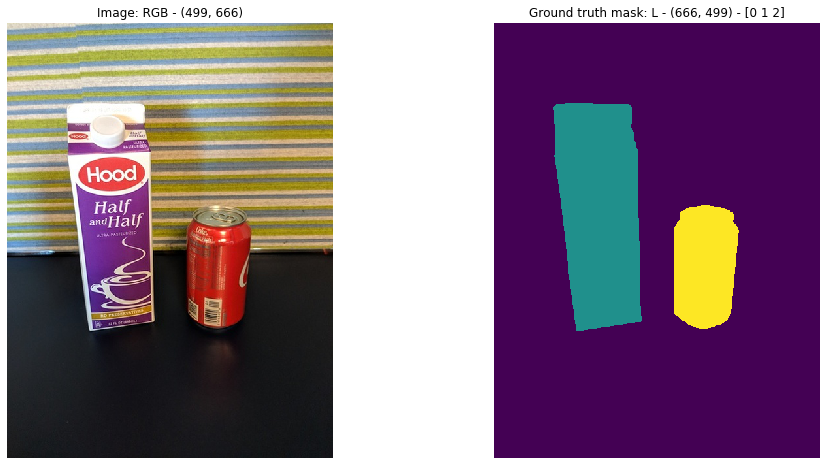

In [5]:
# view the 18th image and its mask
im = Image.open(im_path)
mask = Image.open(mask_path)
mask_np = np.array(mask)
im_label = f'Image: {im.mode} - {im.size}'
mask_label = f'Ground truth mask: {mask.mode} - {mask_np.shape} - {np.unique(mask_np)}'

show_ims([im_path, mask_path], [im_label, mask_label], size=8)

## Instance Segmentation with Pretrained Mask R-CNN Model

We will use a [Mask R-CNN](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn) model which was pre-trained on the [COCO](http://images.cocodataset.org/zips/train2017.zip) dataset (18GB, see [this torchvision page](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn)). The `predict()` funtion outputs a dictionary of keys `scores`, `labels`, `boxes` and `masks`.  The `labels` belong to the 91 categories in the [COCO datasets](http://cocodataset.org/).

Similar to [01_training_introduction notebook](01_training_introduction.ipynb), we can use `get_pretrained_maskrcnn()` to get the pretrained Mask R-CNN model to create a `DetectionLearner`.

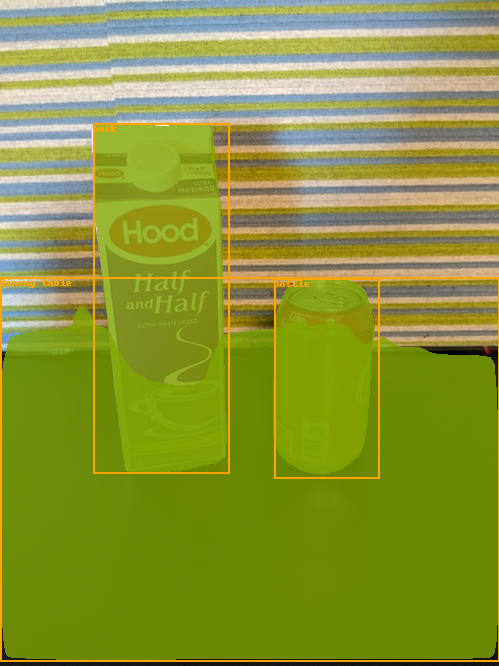

In [6]:
# get pretrained model
detector = DetectionLearner(
    model=get_pretrained_maskrcnn(), 
    device=device,
    labels=coco_labels()[1:],
)
# predict
detections = detector.predict(im_path, threshold=THRESHOLD)

# plot
plot_detections(detections)

As can be seen above, the model mistakes the milk carton as a book, since COCO does not have a "carton" class. It also detects the counter as "dining table".

## Finetuning Mask R-CNN model

Since COCO does not contain the classes "carton", "milk bottle" or "water bottle", we need to fine-tune the pre-trained Mask R-CNN model on our fridge object dataset. This will also remove the other unexpected categories, such as "dining table".  Following the practice in our [01_training_introduction notebook](01_training_introduction.ipynb), we need to prepare the `DetectionDataset` to be used by the `DetectionLearner` during model training.

### Prepare Dataset and Load Images

To load the data, we need to create a dataset object which Torchvision knows how to use.  To make this more convinient, we wrote the `DetectionDataset` class which also knows how to extract annotation information from the Pascal VOC format.  There is an additional parameter `mask_dir` for specifying the mask directory.

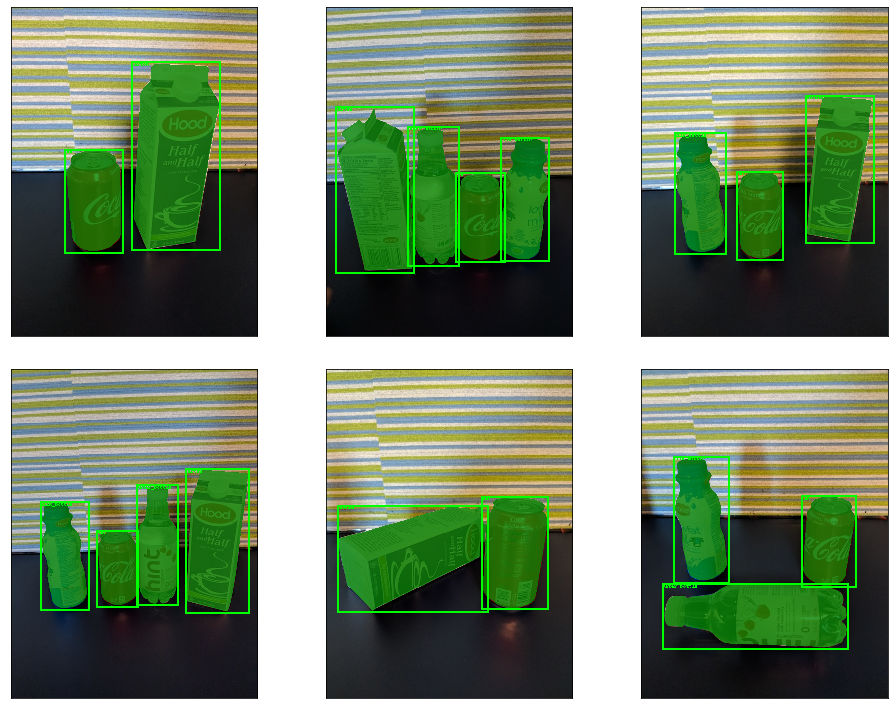

In [7]:
mask_data = DetectionDataset(root=DATA_PATH, mask_dir='segmentation-masks')
mask_data.show_ims(rows=2, seed=168)

### Re-train

We provide the `get_pretrained_maskrcnn()` function to facilitate loading a pre-trained Mask R-CNN model with a ResNet-50-FPN backbone.

In [ ]:
# train
detector = DetectionLearner(
    dataset=mask_data,
    model=get_pretrained_maskrcnn(len(mask_data.labels)+1, min_size=IM_SIZE, max_size=IM_SIZE),
    device=device)
detector.fit(epochs=EPOCHS, lr=0.005, print_freq=30)

Visualize the loss and average precision (ap) over time.

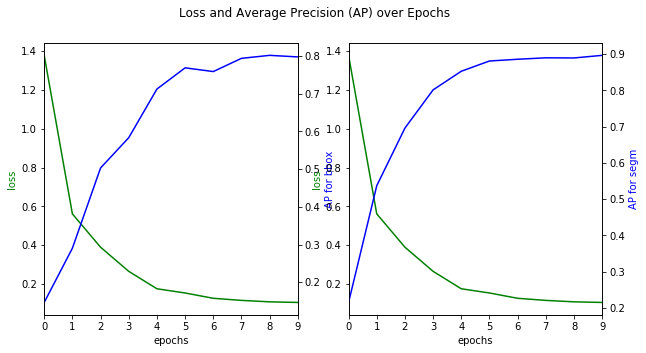

In [9]:
detector.plot_precision_loss_curves()

We can simply run the evaluate() method on our detector to evaluate the results.

In [10]:
e = detector.evaluate()

creating index...
index created!
Test:  [ 0/18]  eta: 0:00:03  model_time: 0.1490 (0.1490)  evaluator_time: 0.0250 (0.0250)  time: 0.2170  data: 0.0400  max mem: 1518
Test:  [17/18]  eta: 0:00:00  model_time: 0.0479 (0.0602)  evaluator_time: 0.0220 (0.0271)  time: 0.1371  data: 0.0460  max mem: 1518
Test: Total time: 0:00:02 (0.1374 s / it)
Averaged stats: model_time: 0.0479 (0.0602)  evaluator_time: 0.0220 (0.0271)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.797
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.974
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.933
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | m

Plot precision-recall curves.  There are two sets of subplots, one for bounding box, the other for mask.

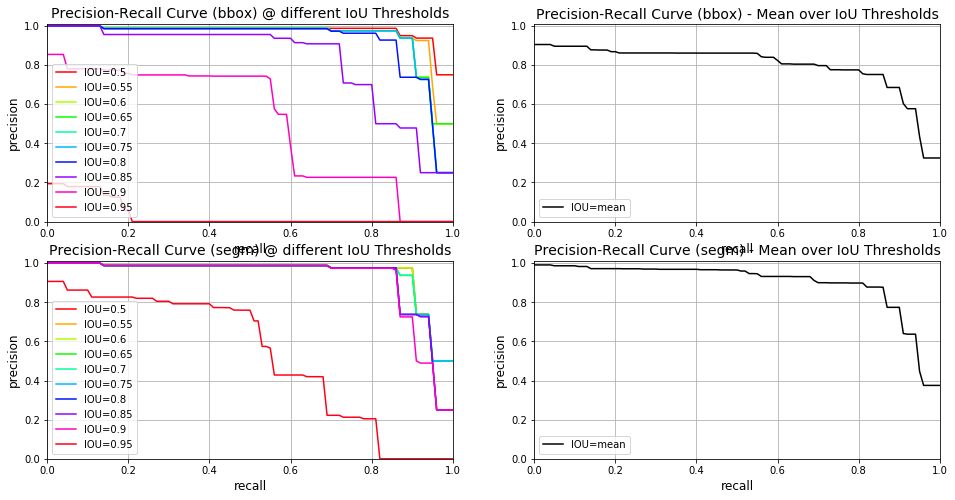

In [11]:
plot_pr_curves(e)

### Predict Single Image

Given the model trained on our fridge objects datasets, we can now run inference again on the image used at the start of this notebook. The two objects are now found correctly, with tightly fitting segmentation masks.

Found 2 objects with confidence above the threshold.


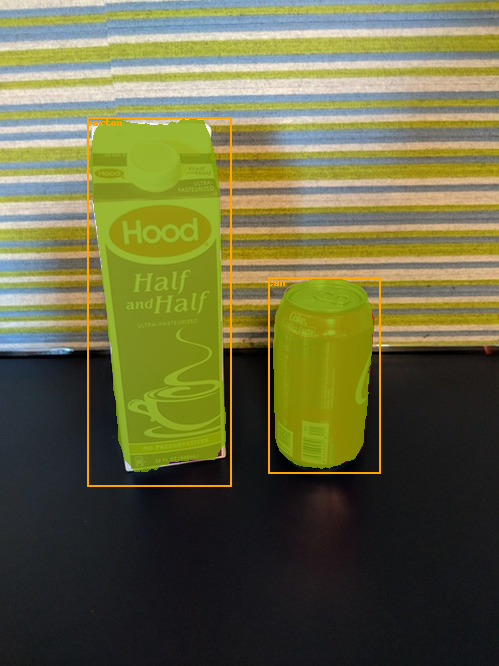

In [12]:
# predict
idx = 18
detections = detector.predict(mask_data.im_paths[idx], threshold=THRESHOLD)
print(f"Found {len(detections['det_bboxes'])} objects with confidence above the threshold.")

# plot
plot_detections(detections)

Note that our dataset is very small to ensure that this notebook runs quickly. Hence the trained model would likely not generalize well to unseen object appearances or backgrounds. 

In [13]:
# preserve some of the notebook outputs
sb.glue("training_losses", detector.losses)
sb.glue("training_average_precision", detector.ap)

## Conclusion

In this notebook, we demonstrate how to use the concepts in our [01_training_introduction notebook](01_training_introduction.ipynb) to prepare an Mask R-CNN model detector fine-tuned on your own dataset for instance segmentation.